# AVIRIS Data - Discovery, Access, and Visualization
##  SBG Science and Applications Technical Interchange Meeting
 
![SBG](images/SBG_NASAAirborne_logo.png)
#![SBG](../images/SBG_NASAAirborne_logo.png)

**Date:** Tuesday May 20- 22, 2025

**Instructors:**  Michele Thornton, Rupesh Shrestha

***

## Overview 

This tutorial will demonstrate Earthdata discovery and direct access of NASA airborne data archived through the ORNL DAAC. We'll explore archived SBG-relevant airborne data using Earthdata Search and then, through a Notebook Tutorial, programmatically access and visualize Level 3 AVIRIS-Next Generation (ANG) Reflectance dataset collected during the Biodiversity Survey of the Cape (BioSCape) Campaign.  BioSCape is an integrated field and airborne campaign in South Africa's Greater Cape Floristic Region (GCFR) where collections occurred in 2023.  The BioSCape Campaign utilzed four NASA airborne instruments to collect UV/visible to short wavelength infrared (UVSWIR) and thermal imaging (TIR) spectroscopy and laser altimetry LiDAR data over terrestrial and aquatic targets.   Airborne Visible InfraRed Imaging Spectrometer - Next Generation (AVIRIS-NG), Portable Remote Imaging SpectroMeter (PRISM), Land, Vegetation, and Ice Sensor (LVIS), and Hyperspectral Thermal Emission Spectrometer (HyTES).

- Learn more about [**BioSCape**](https://www.bioscape.io/)
- Nasa Earthdata Search: [**Discover Earthdata BioSCape Data**](https://search.earthdata.nasa.gov/search?fpj=BioSCape)

The BioSCape Campaign has produced an AVIRIS-NG L3 Resampled Mosaic dataset.  
-  Surface reflectance data (Level 2b) derived from the AVIRIS-NG instrument were resampled to 5-m spatial resolution and mosaiced into a regular tile system of 807 tiles. A given tile includes multiple AVIRIS-NG scenes from multiple flight lines spanning multiple days.  The mosaics in this dataset were generated by stitching together separate scenes and resampling to 5-m resolution in the Hartebeesthoek94 projected coordinate system (WGS-84 datum, EPSG 9221). The mosaic files are distributed on a tiled grid system, and the tile name is included in the file name. Mosaics were generated by manually grouping sets of flight lines into different chunks that should be placed 'in front of' or 'behind' other chunks. The selection criteria included a combination of the weather during observations, flight conditions, flightbox design, and the time the flight was taken. 

> Brodrick, P.G., A.M. Chlus, R. Eckert, J.W. Chapman, M. Eastwood, S. Geier, M. Helmlinger, S.R. Lundeen, W. Olson-Duvall, R. Pavlick, L.M. Rios, D.R. Thompson, and R.O. Green. 2025. BioSCape: AVIRIS-NG L3 Resampled Reflectance Mosaics, V2. ORNL DAAC, Oak Ridge, Tennessee, USA. [https://doi.org/10.3334/ORNLDAAC/2427](https://doi.org/10.3334/ORNLDAAC/2427)

Dataset [**Data Processing Levels**](https://www.earthdata.nasa.gov/learn/earth-observation-data-basics/data-processing-levels) 
- **Level 3**:  Variables mapped on uniform space-time grid scales, usually with some completeness and consistency.

[**NASA JPL BioSCape Data Portal**](https://popo.jpl.nasa.gov/mmgis-aviris/?mission=BIOSCAPE)

![BioSCape_MMGIS](images/BioSCape_MMGIS_rs70.png)
#![BioSCape_MMGIS](../images/BioSCape_MMGIS_rs70.png)



- **Demo**:  Live Demo of Earthdata Search 
-  **Tutorial**:  Programmatic Discovery and Access of Airborne Data:  BioSCape Campaign AVIRIS-NG Resampled Mosaic (L3) Reflectance
---

## Demo:  Earthdata Search - ORNL DAAC Airborne Facility Instrument and Campaign Collections

[**NASA Earthdata Search**](https://search.earthdata.nasa.gov/)

![Earthdata Search](images/earthdatasearch60.png)
#![Earthdata Search](../images/earthdatasearch60.png)

---

## Tutorial:  Programmatic Discovery and Access of Airborne Data

**BioSCape Campaign AVIRIS-NG Reflectance Level 3 Mosaic Dataset**

### Requirements

In [1]:
import earthaccess
import geopandas as gpd
import pyproj
from pyproj import Proj
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import linecache
from glob import glob
import pandas as pd
from shapely.ops import transform
from shapely.ops import orient
from shapely.geometry import Polygon, MultiPolygon
import folium
import hvplot.xarray
import holoviews as hv
hvplot.extension('bokeh')
import math
import rioxarray as rx
from rioxarray import merge
import rasterio

## Step 1: Authentication and Airbone Datasets Search Examples with earthaccess 

![earthaccess](../images/earthaccess.png)
![earthaccess](images/earthaccess.png)

[**`earthaccess`**](https://www.earthdata.nasa.gov/news/blog/earthaccess-earth-science-data-simplifiedl) is a Python library that simplifies data discovery and access to NASA Earthdata data by providing an abstraction layer to NASA's APIs for programmatic access.  

In this tutorial we'll use earthaccess to:
- handle authentication with NASA's Earthdata Login (EDL), 
- search the NASA Earthdata Data holdings using NASA's Common Metadata Repository (CMR), and 
- provide direct cloud file access 

**Earthdata Login**

NASA [**`Earthdata Login`**](https://urs.earthdata.nasa.gov/)  is a user registration and profile management system for users getting Earth science data from NASA Earthdata.  If you download or access NASA Earthdata data, you need an Earthdata Login. 

Using `earthaccess` we'll login and authentice to NASA Earthdata Login.
- For this exercise, we will be prompted for and interactively enter our Eathdata Login credentials (login, password)

In [2]:
auth = earthaccess.login()

### 1.1 `earthaccess` to search the NASA Common Metadata Repository for a specific airborne `instrument`

In [3]:
results = earthaccess.search_datasets(instrument="AVIRIS-3")
#results = earthaccess.search_datasets(instrument="AVIRIS-NG")
#results = earthaccess.search_datasets(instrument="AVIRIS") # AVIRIS-Classic
#results = earthaccess.search_datasets(instrument="MASTER")
#results = earthaccess.search_datasets(instrument="HYTES")
#results = earthaccess.search_datasets(instrument="PRISM")
print(f"Total Datasets (results) found: {len(results)}")

Total Datasets (results) found: 4


List the short-name for each dataset

In [4]:
for item in results:
    summary = item.summary()
    print(summary["short-name"])

ABoVE_Airborne_AV3_V1_2388
AV3_L1B_RDN_2356
AV3_L2A_RFL_2357
AV3_L2B_GHG_2358


### 1.2 Search UMM-G for Specific Campaigns
- AVIRIS-3 datasets contain `campaign` information in the Unified Metadata Model-Granule (UMM-G) [`AdditionalAttributes`](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#c-additional-attribute)
- List the campaigns and number of granules in each campaign
- Note that at the time of this workshop, this functionality is specific to AVIRIS-3 Datasets

In [5]:
def  get_campaign_names(granules):
    """get campaign names for all granules"""
    c = []
    for g in granules:
        for attrs in vars(g)['render_dict']['umm']['AdditionalAttributes']:
            if attrs['Name'] == 'Campaign':
                c += attrs['Values']
    return c

# earthdata search
granules = earthaccess.search_data(
    #short_name = 'AV3_L1B_RDN_2356',
    doi="10.3334/ORNLDAAC/2356"
)

campaigns = get_campaign_names(granules)

#print campaign names and granules
for name in list(set(campaigns)):
    print(f'{name} --> {campaigns.count(name)} granules')

DEVELOP Santa Clarita Valley Ecological Conservation --> 28 granules
ABoVE --> 1405 granules
GEMx --> 39 granules
SHIFT --> 55 granules
FireSense --> 1281 granules
GHG --> 1670 granules
NEON --> 16 granules
AiRMAPS --> 2572 granules
WDTS --> 507 granules
2025 LA Fires --> 224 granules
Carbon Mapper --> 3845 granules
SCOAPE-II --> 625 granules
Sacramento Delta --> 1030 granules
Calibration / Validation / Instrument Science / Testing --> 222 granules


**If you know a Campaign flown with AVIRIS-3, you can directly query the `AdditionalAttributes`**

In [6]:
doi="10.3334/ORNLDAAC/2356" # AV3_L1B_RDN_2356
query = earthaccess.DataGranules().doi(doi)
query.params['attribute[]'] = 'string,Campaign,SHIFT' 
l1b = query.get_all()
print(f'Granules found: {len(l1b)}')

Granules found: 55


### 1.3 Search by **`Project`** knowing our dataset of interest was part of the BioSCape project.

In [7]:
results = earthaccess.search_datasets(project="BioSCape")
print(f"Total Datasets (results_projects) found: {len(results)}")

Total Datasets (results_projects) found: 9


For the instrument=="AVIRIS-NG" search, let's look at the first result to see all of the CMR values that are returned
- The first dataset listed is from the ABoVE Campaign
- We see many useful fields for any one dataset including: `short-name`, `concept-id`, the `S3BucketAndObjectPrefixNames`

In [8]:
for index, item in enumerate(results):
    if index == 0:
        summary = item.summary()
        print(summary)

{'short-name': 'OLVIS1A', 'concept-id': 'C1959080871-NSIDC_ECS', 'version': '1', 'file-type': "[{'FormatType': 'Native', 'Format': 'JPEG', 'FormatDescription': 'HTTPS'}]", 'get-data': ['https://nsidc.org/icebridge/portal/map', 'https://n5eil01u.ecs.nsidc.org/ICEBRIDGE/OLVIS1A.001', 'https://search.earthdata.nasa.gov/search?q=OLVIS1A+V001', 'https://nsidc.org/data/data-access-tool/OLVIS1A/versions/1/']}


Let's look at `short-name` for all of the search **results**

In [9]:
for item in results:
    summary = item.summary()
    print(summary["short-name"])

OLVIS1A
OLVIS1A
LVISF2
LVISF2
Acoustic_Data_Cape_Floristic_2372
BIOSCAPE_COASTAL_CARBON
BioSCape_ANG_V02_L3_RFL_Mosaic_2427
LVISF1B
LVISF1B


- **`BioSCape_ANG_V02_L3_RFL_Mosaic_2427`** is the `short-name` of the dataset of interest for this tutorial. 

Let's use **`earthaccess`** to query the [**`BioSCape: AVIRIS-NG L3 Resampled Reflectance Mosaics, V2`**](https://search.earthdata.nasa.gov/search/granules?p=C3523930138-ORNL_CLOUD) data to discover the files within that dataset.

In [10]:
results = earthaccess.search_data(
    short_name = 'BioSCape_ANG_V02_L3_RFL_Mosaic_2427', 
)
print(f"Total granules found: {len(results)}")

Total granules found: 871


Let's look at the first 2 results and examine the details of the granule-level CMR metadata information

In [11]:
# granule-level CMR metadata information
results[:2]

[Collection: {'ShortName': 'BioSCape_ANG_V02_L3_RFL_Mosaic_2427', 'Version': '2'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': 17.6241, 'EastBoundingCoordinate': 26.3228, 'NorthBoundingCoordinate': -31.1563, 'SouthBoundingCoordinate': -35.0058}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-10-22T00:00:00Z', 'EndingDateTime': '2023-11-26T23:59:59Z'}}
 Size(MB): 0.4013175964355469
 Data: ['https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/BioSCape_ANG_V02_L3_RFL_Mosaic_tiles.geojson'],
 Collection: {'ShortName': 'BioSCape_ANG_V02_L3_RFL_Mosaic_2427', 'Version': '2'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 19.0777, 'Latitude': -32.7331}, {'Longitude': 19.0832, 'Latitude': -32.6439}, {'Longitude': 18.9758, 'Latitude': -32.6393}, {'Longitude': 18.9702, 'Latitude': -32.7285}, {'Longitu

## Step 2. Further Define and Refine our Search Parameters
### 2.1 Define more search parameters to limit our search
- `bounding_box`
- `temporal` range
-  `granule_name` refined 

Let's first create and visualize a **`bounding box`** for an area-of-interest within the South Africa Greater Cape Floristic Region (GCFR) of the BioSCape Campaign 

In [12]:
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import transform
import pyproj

def create_geo_bb(coordinates, crs_in='epsg:4326', crs_out='epsg:4326'):
    
    polygon_shape = Polygon(coordinates)

    if crs_in != crs_out:
      project_in = pyproj.Proj(init=crs_in)
      project_out = pyproj.Proj(init=crs_out)
    
      polygon_shape = transform(pyproj.Transformer.from_proj(project_in, project_out, always_xy=True).transform, polygon_shape)
    
    polygon = gpd.GeoDataFrame(geometry=[polygon_shape], crs=crs_out)
    return polygon

coordinates = [
    (17.9907, -33.1243),
    (18.2469, -33.1243),
    (18.2469, -33.2817),
    (17.9907, -33.2817),
    (17.9907, -33.1243)
]

polygon_gdf = create_geo_bb(coordinates)
print(polygon_gdf)

                                            geometry
0  POLYGON ((17.9907 -33.1243, 18.2469 -33.1243, ...


In [13]:
#polygon_gdf.crs

In [14]:
polygon_gdf.explore(fill=False, tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', attr='Google')

**We'll use this bounding box and temporal parameters to refine our search of BioSCape AVIRIS-NG L3 files in our region and time of interest**

Again, using **`earthaccess`** we can query the [**`BioSCape: AVIRIS-NG L3 Resampled Reflectance Mosaics, V2`**](https://search.earthdata.nasa.gov/search/granules?p=C3523930138-ORNL_CLOUD) data to discover files within the spatial and temporal subset of interest.

- recall we discovered in our Earthdata Search investigation that datasets have NASA Earthdata Unique Identifiers (e.g. DOI, ConceptID, short_name)

- Dataset of interest short_name:  **`BioSCape_ANG_V02_L3_RFL_Mosaic_2427`**

- The BioSCape Airborne Campaign took place from 2023-10-22 to 2023-11-26

In [15]:
# bounding lon, lat as a list of tuples
bounds = polygon_gdf.geometry.apply(orient, args=(1,))
# simplifying the polygon to bypass the coordinates 
# limit of the CMR with a tolerance of .01 degrees
xy = bounds.simplify(0.01).get_coordinates()

date_range = ("2023-10-22", "2023-11-26")  

results = earthaccess.search_data(
    short_name = 'BioSCape_ANG_V02_L3_RFL_Mosaic_2427', 
    polygon=list(zip(xy.x, xy.y)),
    temporal = date_range,
    granule_name=('*AVIRIS-NG_BIOSCAPE_V02_L3*')
)
print(f"Total granules found: {len(results)}")

Total granules found: 8


**For our search parameters, let's explore the granules found**  
- Let's look at the first result

In [16]:
results[:2]

[Collection: {'ShortName': 'BioSCape_ANG_V02_L3_RFL_Mosaic_2427', 'Version': '2'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 18.2881, 'Latitude': -33.2345}, {'Longitude': 18.2943, 'Latitude': -33.1453}, {'Longitude': 18.1864, 'Latitude': -33.1401}, {'Longitude': 18.1801, 'Latitude': -33.2293}, {'Longitude': 18.2881, 'Latitude': -33.2345}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-10-22T00:00:00Z', 'EndingDateTime': '2023-11-26T23:59:59Z'}}
 Size(MB): 604.1506757736206
 Data: ['https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_26_9_UNC.nc', 'https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_26_9_QL.tif', 'https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_26_9_RFL.nc'],
 Colle

In [17]:
results[7]

Collection: {'ShortName': 'BioSCape_ANG_V02_L3_RFL_Mosaic_2427', 'Version': '2'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 18.1801, 'Latitude': -33.2293}, {'Longitude': 18.1864, 'Latitude': -33.1401}, {'Longitude': 18.0785, 'Latitude': -33.1348}, {'Longitude': 18.0721, 'Latitude': -33.224}, {'Longitude': 18.1801, 'Latitude': -33.2293}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-10-22T00:00:00Z', 'EndingDateTime': '2023-11-26T23:59:59Z'}}
Size(MB): 6034.285764694214
Data: ['https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_26_8_QL.tif', 'https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_26_8_UNC.nc', 'https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_26_8_RFL.nc']

**You can download these files directly to your local machine by clicking on any of the files**
- We also see that these data are **Cloud Hosted:** True

### 2.2 Create and Visualize the **`Bounding Boxes`** of the subset of files

From each granule, we'll use the CMR `Geometry` information to create a plot of the AVIRIS-3 flight lines from our temporal and spatial subset

Below, we define two functions to plot the search results over a basemap
- Function 1:  converts UMM geometry to multipolygons
  -- `UMM` stands for NASA's Unified Metadata Model
- Function 2: converts the Polygon List [ ] to a **`geopandas`** dataframe

In [18]:
def convert_umm_geometry(gpoly):
    """converts UMM geometry to multipolygons"""
    multipolygons = []
    for gl in gpoly:
        ltln = gl["Boundary"]["Points"]
        points = [(p["Longitude"], p["Latitude"]) for p in ltln]
        multipolygons.append(Polygon(points))
    return MultiPolygon(multipolygons)

def convert_list_gdf(datag):
    """converts List[] to geopandas dataframe"""
    # create pandas dataframe from json
    df = pd.json_normalize([vars(granule)['render_dict'] for granule in datag])
    # keep only last string of the column names
    df.columns=df.columns.str.split('.').str[-1]
    # convert polygons to multipolygonal geometry
    df["geometry"] = df["GPolygons"].apply(convert_umm_geometry)
    # return geopandas dataframe
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
    
subset_gdf = convert_list_gdf(results)
subset_gdf.crs
#subset_gdf.drop('Version', axis=1, inplace=True)
#subset_gdf.explore(fill=False, tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', attr='Google')

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
# let's visualize the bounding boxes of the selected files
subset_gdf = convert_list_gdf(results)

mapObj = folium.Map(location=[-33.1456, 18.0622], zoom_start=11, control_scale=True)
#-118.2036, 34.2705
#folium.GeoJson(gdf).add_to(mapObj)
subset_gdf.drop('Version', axis=1, inplace=True)
folium.GeoJson(subset_gdf, name="SUBSET FLIGHT LINES", color="blue", style_function=lambda x: {"fillOpacity": 0}).add_to(mapObj)

folium.GeoJson(polygon_gdf, name="LA FIRE SUBSET AREA", color="white", style_function=lambda x: {"fillOpacity": 0}).add_to(mapObj)
#folium.GeoJson(lasubset, name="SUBSET FLIGHT LINES", style_function=lambda x: {"fillOpacity": 0}).add_to(mapObj)

# create ESRI satellite base map
esri = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'
folium.TileLayer(tiles = esri, attr = 'Esri', name = 'Esri Satellite', overlay = False, control = True).add_to(mapObj)
folium.LayerControl().add_to(mapObj)
mapObj

**Let's add the `GranuleUR` to the visualization of the selected tile bounding boxes**

In [20]:
#Visualize the selected tile bounding boxes and the GranuleUR
#m = AVNG_CP[['fid','geometry']].explore('fid')
m = subset_gdf[['GranuleUR', 'geometry']].explore('GranuleUR', tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', attr='Google')
#explore('LandType', tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', attr='Google')
m

**We have a subset of files of interest for our region of interest.  Now let's see how to access those files**

## Step 3.  Cloud-based Access Methods 

Datasets in NASA Earthdata Cloud
- NASA Earthdata is in AMAZON AWS us-west-2 region (physically in Oregon)
- Most data are in AWS Cloud Data Storage (S3) Buckets in this cloud
- Access Earthdata Cloud from another Cloud that is in the same region - the openscapes 2i2c Hub is in that region
- Airborne (AVIRIS) files can be big, processinge it in the cloud may be advantageous, saving your local device storage

**Recall from our earthaccess search `results`, each granule of the dataset has 3 data files:** 
- **`*_QL.tif`**
- **`*_RFL.nc`**
- **`*_UNC.nc`**

Let's use the `results` from earthaccess API search to display the [`data_links`](https://earthaccess.readthedocs.io/en/latest/user-reference/granules/granules/#earthaccess.results.DataGranule.data_links) of the Quick Look geoTIFF files

In [21]:
def get_s3_links(g, suffix_str):
    return [i for i in g.data_links(access="direct") if i.endswith(suffix_str)][0]

tif_f = []
for g in results:
    tif_f.append(get_s3_links(g, 'QL.tif'))
tif_f

['s3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_26_9_QL.tif',
 's3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_27_7_QL.tif',
 's3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_27_9_QL.tif',
 's3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_26_7_QL.tif',
 's3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_27_8_QL.tif',
 's3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_25_7_QL.tif',
 's3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_25_8_QL.tif',
 's3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_26_8_QL.tif']

### 3.1 Directly Open and Access NASA Earthdata from the AWS S3 Session 

Calling open( ) from the **`earthaccess`** API library on an S3FileSystem object...
- returns an S3File object, which mimics the standard Python file protocol, allowing you to read and write data to S3 objects
- returns a list of file-like objects that can be used to access files hosted on S3 third party libraries like xarray
- **`*_paths`** contains references to files on the remote filesystem.  The `ornl-cumulus-prod-public` is the S3 bucket in AWS us-west-2 region

In [22]:
gtiff_paths = earthaccess.open(tif_f, provider="ORNL_CLOUD")

QUEUEING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/8 [00:00<?, ?it/s]

In [23]:
gtiff_paths

[<File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_26_9_QL.tif>,
 <File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_27_7_QL.tif>,
 <File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_27_9_QL.tif>,
 <File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_26_7_QL.tif>,
 <File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_27_8_QL.tif>,
 <File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_25_7_QL.tif>,
 <File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE

Now that we've opened the S3 objects, we can treat them as if they are local files.

Let's open and visualize the geoTIFF files using familiar Python packages like rioxarray 
- First we'll determine the crs and visualize one file

In [24]:
with rasterio.open(gtiff_paths[7]) as dataset:
    # Read the CRS
    crs = dataset.crs 
    print(f"The CRS of the GeoTIFF is: {crs}")
    print(f"The type of CRS is: {type(crs)}")

The CRS of the GeoTIFF is: EPSG:3857
The type of CRS is: <class 'rasterio.crs.CRS'>


Let's add and visualize a plot location.  We'll create a spectral profile of this plot location in a subsequent code block.

In [25]:
terr_lat = -33.1733
terr_lon = 18.1374
aqua_lat = -33.1925
aqua_lon = 18.1166
# translate coordinates
from pyproj import Proj
p = Proj("EPSG:3857", preserve_units=False)
terr_x,terr_y = p(terr_lon, terr_lat)
aqua_x, aqua_y = p(aqua_lon, aqua_lat)
print('terr_easting:', terr_x)
print('terr_northing', terr_y)
print('aqua_easting:', aqua_x)
print('aqua_northing', aqua_y)


terr_easting: 2019046.13231392
terr_northing -3918329.2959917258
aqua_easting: 2016730.68690542
aqua_northing -3920883.0819986546


Visualize the tile geoTIFF and plot location

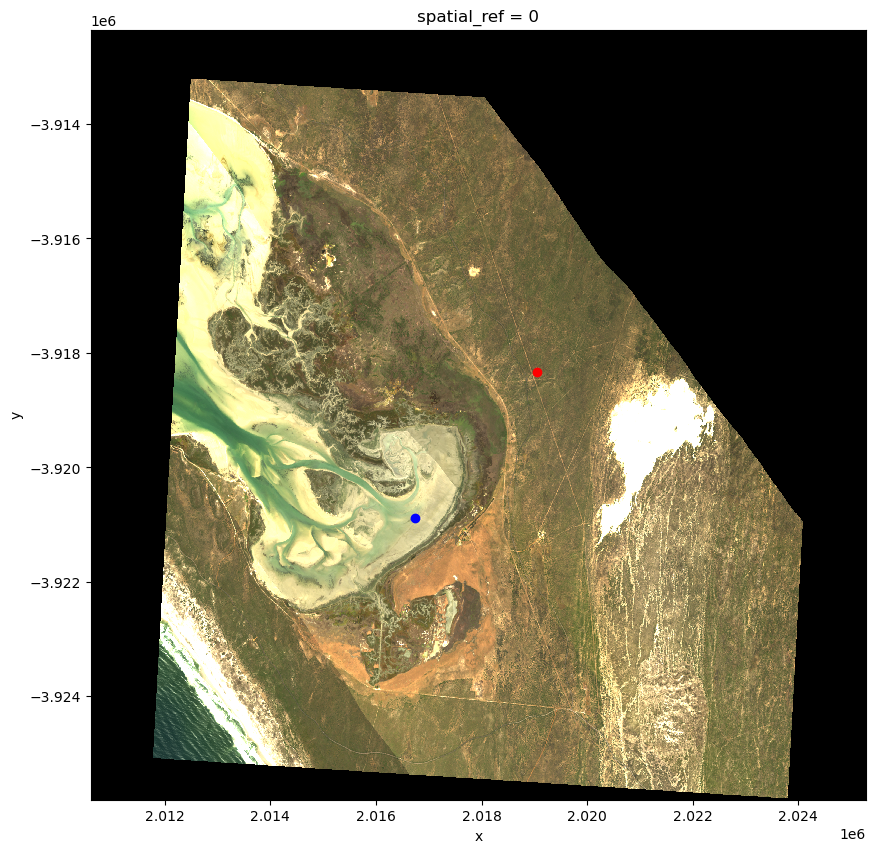

In [26]:
# Open the GeoTIFF file
raster = rx.open_rasterio(gtiff_paths[7])

# Plot the RGB image
plt.figure(figsize=(10, 10))
raster.plot.imshow(rgb="band")
plt.scatter(terr_x,terr_y, color='red')
plt.scatter(aqua_x,aqua_y, color='blue')
plt.show()


And now we'll merge the 8 files and visualize the data available over our region of interest

In [27]:
data_arrays = []
for g in gtiff_paths:
    data_arrays.append(rx.open_rasterio(g))

merged_array = rx.merge.merge_arrays(data_arrays, method='last')
merged_array.rio.to_raster('merged_image.tif')

#plt.figure(figsize=(10, 10))
#merged_array.plot.imshow(rgb='band')
#plt.show()


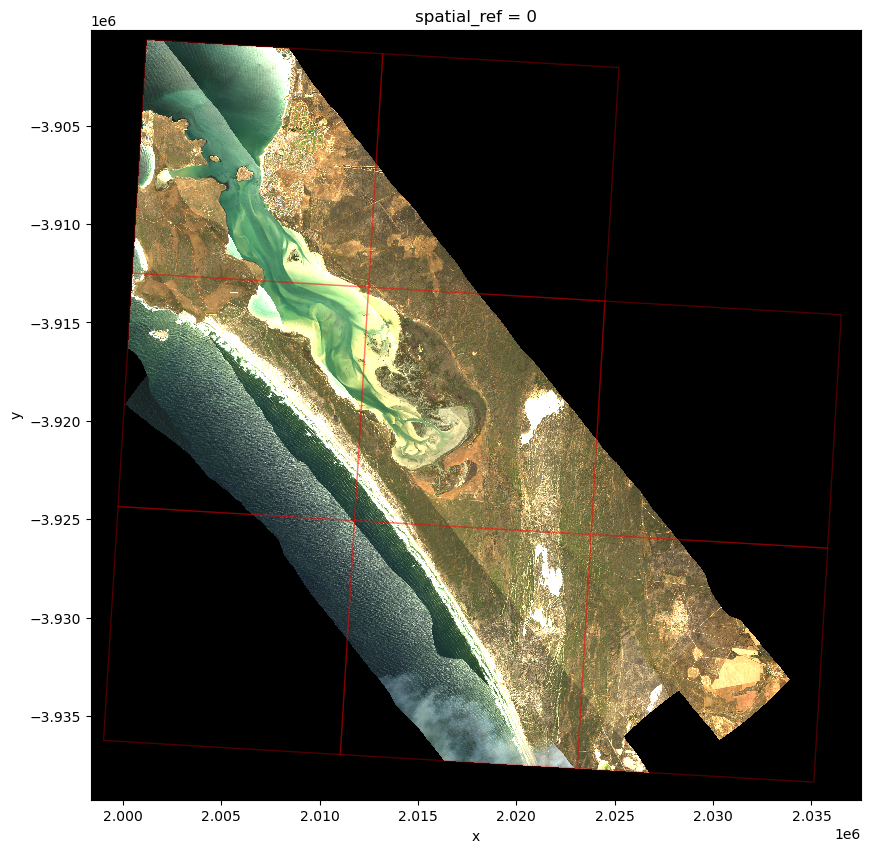

In [28]:
ANG_L3_EPSG = 'EPSG:3857' 
subset_gdf_9221 = subset_gdf.to_crs(ANG_L3_EPSG)  
fig, ax = plt.subplots(figsize=(10, 10))
merged_array.plot.imshow(rgb='band', ax=ax)

subset_gdf_9221.plot(ax=ax, facecolor='none', edgecolor='red', alpha=0.3)
plt.show()

### Step 3.2 List S3 Links for Mosaic AVIRIS-NG 425-band Reflectance netCDF Files
- Again, we'll use the `results` from earthaccess API search to display the [`data_links`](https://earthaccess.readthedocs.io/en/latest/user-reference/granules/granules/#earthaccess.results.DataGranule.data_links) of the netCDF files

In [29]:
def get_s3_links(g, suffix_str):
    return [i for i in g.data_links(access="direct") if i.endswith(suffix_str)][0]

rfl_f = []
for g in results:
    rfl_f.append(get_s3_links(g, 'RFL.nc'))
rfl_f

['s3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_26_9_RFL.nc',
 's3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_27_7_RFL.nc',
 's3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_27_9_RFL.nc',
 's3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_26_7_RFL.nc',
 's3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_27_8_RFL.nc',
 's3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_25_7_RFL.nc',
 's3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_25_8_RFL.nc',
 's3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_26_8_RFL.nc']

**Recall that these are Multifile Granules with 3 files per Granule.  We've selected just the netCDF files in** **`granule_arr`**

### Step 3.3 Directly Open, Access, and Visualize AVIRIS-NG Mosaic Data from the AWS S3 Session 
Using **`xarray`** and the **`earthaccess.open`** function we can directly read from a remote filesystem, but not download a file.  

In [30]:
paths = earthaccess.open(rfl_f, provider="ORNL_CLOUD")

QUEUEING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/8 [00:00<?, ?it/s]

In [31]:
paths

[<File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_26_9_RFL.nc>,
 <File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_27_7_RFL.nc>,
 <File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_27_9_RFL.nc>,
 <File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_26_7_RFL.nc>,
 <File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_27_8_RFL.nc>,
 <File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_25_7_RFL.nc>,
 <File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE

In [42]:
ds_set = xr.open_dataset(paths[7], engine="h5netcdf")
ds_set

<xarray.Dataset> Size: 32kB
Dimensions:              (easting: 2000, northing: 2000)
Coordinates:
  * easting              (easting) float64 16kB 7.6e+05 7.6e+05 ... 7.7e+05
  * northing             (northing) float64 16kB 9.3e+05 9.3e+05 ... 9.2e+05
Data variables:
    transverse_mercator  |S1 1B ...
Attributes: (12/22)
    Conventions:                       CF-1.6
    date_created:                      2025-04-23T20:35:46Z
    summary:                           Mosaic of AVIRIS-NG L2A Reflectance da...
    keywords:                          Imaging Spectroscopy, AVIRIS, AVIRIS-NG
    sensor:                            Airborne Visible / Infrared Imaging Sp...
    instrument:                        AVIRIS-NG
    ...                                ...
    ncei_template_version:             NCEI_NetCDF_Grid_Template_v2.0
    title:                             AVIRIS-NG L3 Mosaiced Surface Reflecta...
    processing_level:                  L3
    time_coverage_start:               2023-10-22T00:00:00Z
    time_coverage_end:                 2024-11-26T23:59:59Z
    product_version:                   002

Notice that this `xarray.Dataset` is limited in what is showing and has no variables.  

**The netCDF data model for these data includes multi-group hierarchies within a single file where each `group` maps to an xarray.Dataset**
- In xarray, it is recommended to use DataTree to represent hierarchical data
>netCDF groups can only be loaded individually as Dataset objects, a whole file of many nested groups can be loaded as a single xarray.DataTree object. To open a whole netCDF file as a tree of groups use the xarray.open_datatree() function. 
- This implementation in XArray is decribed here: https://docs.xarray.dev/en/stable/user-guide/io.html

In [43]:
ds = xr.open_datatree(paths[7], engine="h5netcdf")
ds

<xarray.DataTree>
Group: /
│   Dimensions:              (easting: 2000, northing: 2000)
│   Coordinates:
│     * easting              (easting) float64 16kB 7.6e+05 7.6e+05 ... 7.7e+05
│     * northing             (northing) float64 16kB 9.3e+05 9.3e+05 ... 9.2e+05
│   Data variables:
│       transverse_mercator  |S1 1B ...
│   Attributes: (12/22)
│       Conventions:                       CF-1.6
│       date_created:                      2025-04-23T20:35:46Z
│       summary:                           Mosaic of AVIRIS-NG L2A Reflectance da...
│       keywords:                          Imaging Spectroscopy, AVIRIS, AVIRIS-NG
│       sensor:                            Airborne Visible / Infrared Imaging Sp...
│       instrument:                        AVIRIS-NG
│       ...                                ...
│       ncei_template_version:             NCEI_NetCDF_Grid_Template_v2.0
│       title:                             AVIRIS-NG L3 Mosaiced Surface Reflecta...
│       processing_level:                  L3
│       time_coverage_start:               2023-10-22T00:00:00Z
│       time_coverage_end:                 2024-11-26T23:59:59Z
│       product_version:                   002
├── Group: /reflectance
│       Dimensions:      (wavelength: 425, northing: 2000, easting: 2000)
│       Coordinates:
│         * wavelength   (wavelength) float32 2kB 377.2 382.2 ... 2.496e+03 2.501e+03
│       Data variables:
│           fwhm         (wavelength) float32 2kB ...
│           reflectance  (wavelength, northing, easting) float32 7GB ...
├── Group: /obs
│       Dimensions:             (northing: 2000, easting: 2000)
│       Data variables:
│           path_length         (northing, easting) float32 16MB ...
│           to_sensor_azimuth   (northing, easting) float32 16MB ...
│           to_sensor_zenith    (northing, easting) float32 16MB ...
│           to_sun_azimuth      (northing, easting) float32 16MB ...
│           to_sun_zenith       (northing, easting) float32 16MB ...
│           solar_phase         (northing, easting) float32 16MB ...
│           slope               (northing, easting) float32 16MB ...
│           aspect              (northing, easting) float32 16MB ...
│           cosine_i            (northing, easting) float32 16MB ...
│           utc_time            (northing, easting) float32 16MB ...
│           earth_sun_distance  (northing, easting) float32 16MB ...
└── Group: /scene_info
        Dimensions:      (northing: 2000, easting: 2000, scene_ids: 3647)
        Dimensions without coordinates: scene_ids
        Data variables:
            scene_id     (northing, easting) uint16 8MB ...
            scene_names  (scene_ids) <U22 321kB ...

Now we see that the netCDF files contains Groups (3)
- reflectance
- obs
- scene info

We'll open the file again as a datatree, and then convert it to a dataset with the `reflectance` variable

In [44]:
rfl_ds = xr.open_datatree(paths[7], 
                              engine='h5netcdf').reflectance.to_dataset()
rfl_ds

<xarray.Dataset> Size: 7GB
Dimensions:      (wavelength: 425, northing: 2000, easting: 2000)
Coordinates:
  * easting      (easting) float64 16kB 7.6e+05 7.6e+05 ... 7.7e+05 7.7e+05
  * northing     (northing) float64 16kB 9.3e+05 9.3e+05 ... 9.2e+05 9.2e+05
  * wavelength   (wavelength) float32 2kB 377.2 382.2 ... 2.496e+03 2.501e+03
Data variables:
    fwhm         (wavelength) float32 2kB ...
    reflectance  (wavelength, northing, easting) float32 7GB ...

Next, we'll subset the wavelenghts that correspond to RGB bands and visualize the true color image with holoview

In [45]:
ds_rgb = rfl_ds.reflectance.sel(wavelength=[637, 552, 462], method="nearest")

In [46]:
ds_rgb.hvplot.rgb('easting', 'northing', rasterize=True,robust=True, data_aspect=1, aspect='equal', 
                  bands='wavelength', frame_width=600)

:DynamicMap   []
   :RGB   [easting,northing]   (R,G,B)

In [ ]:
#### false color composite
#ds_fcc = rfl_ds.reflectance.sel(wavelength=[800, 637, 552], method="nearest")
#ds_fcc.hvplot.rgb('easting', 'northing', rasterize=True,robust=True, data_aspect=1, aspect='equal', 
#                  bands='wavelength', frame_width=600)

In [ ]:
#### The Minimum Noise Fraction transformation (MNF) composite images (B456, B546, and B561), can be used to enhance the delineation of different rock types
#ds_mnf = rfl_ds.reflectance.sel(wavelength=[456, 546, 561], method="nearest")
#ds_mnf.hvplot.rgb('easting', 'northing', rasterize=True,robust=True, data_aspect=1, aspect='equal', 
#                  bands='wavelength', frame_width=600)

### Step 3.4 Plot Terrestrial and Aquatic Plots Spectral Profiles

Convert the latitude longitude plots to the AVIRIS-NG netCDF files projection

In [47]:
#latitude = -33.1733
#longitude = 18.1374
# translate coordinates
#from pyproj import Proj
p = Proj("EPSG:9221", preserve_units=False)
terr_x,terr_y = p(terr_lon, terr_lat)
print('terr_easting:',terr_x)
print('terr_northing', terr_y)
aqua_x,aqua_y = p(aqua_lon, aqua_lat)
print('aqua_easting:', aqua_x)
print('aqua_northing', aqua_y)

terr_easting: 765692.1777874201
terr_northing 926021.7440919735
aqua_easting: 763899.5907153768
aqua_northing 923763.8287129314


Define a list of bands that are atmospheric windows

In [48]:
# Define a list of wavelengths that are "bad" 
bblist = np.ones((425,))  # create a 1D array with values ones
# set tails and atmospheric window to zero
bblist[0:14] = 0        # tail
bblist[193:210] = 0     # atmospheric window
bblist[281:320] = 0     # atmospheric window
bblist[405:] = 0        # tail

Select and plot the spectral profiles from the nearest pixel of the terrestrial and aquatic pixel plot locations

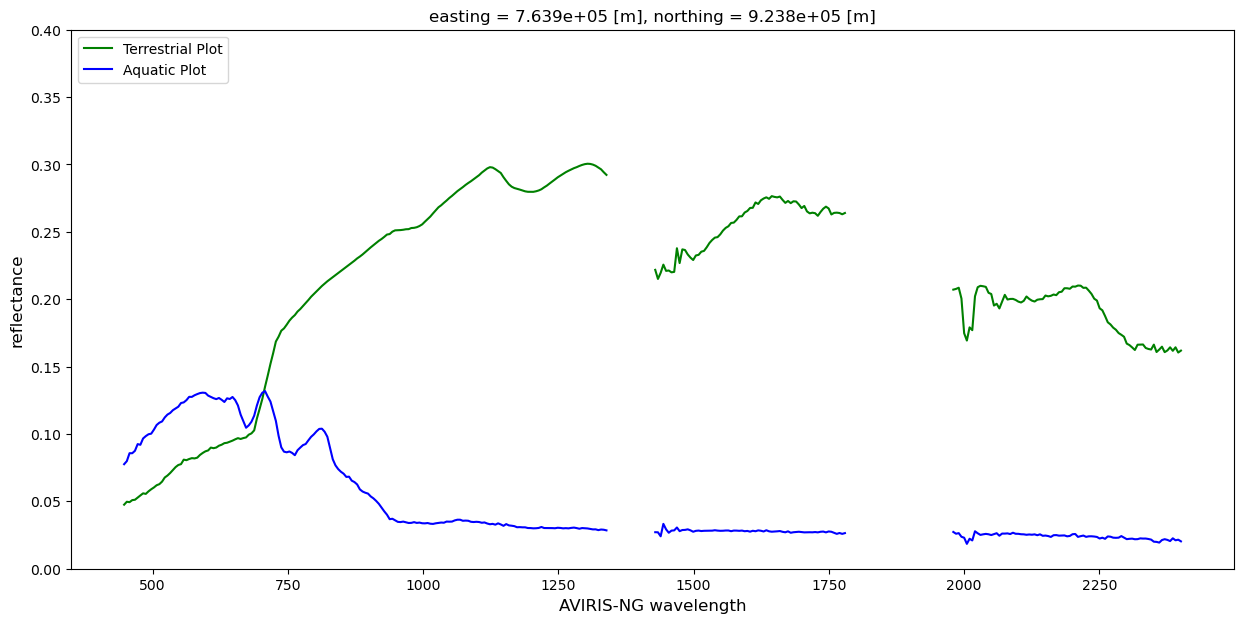

In [49]:
# Compare spectra from a terrestrial and aquatic plot
terr_plot = rfl_ds.reflectance.sel(easting=terr_x, northing=terr_y, method='nearest')
terr_plot[bblist == 0] = np.nan
aqua_plot = rfl_ds.reflectance.sel(easting=aqua_x, northing=aqua_y, method='nearest')
aqua_plot[bblist == 0] = np.nan

terr_plot.plot.line(ylim=(0,.4), color = 'g', label="Terrestrial Plot")
aqua_plot.plot.line(ylim=(0,.4),color = 'b', label="Aquatic Plot")

plt.rcParams['figure.figsize'] = [15,7]
plt.xlabel('AVIRIS-NG wavelength', fontsize=12)
plt.ylabel('reflectance', fontsize=12)
plt.legend(loc="upper left")
plt.show()


These next block of code will merge the selected files.  We will not run this during the workshop.  uncomment to run.  

In [ ]:
#s3_obj = []
#for fh in paths:
#    s3_obj.append(xr.open_datatree(fh, engine='h5netcdf', 
#                                   chunks='auto').reflectance.to_dataset())
#ds = xr.combine_by_coords(s3_obj, combine_attrs='override')